# Doctors' locations

- Each location will be assigned to the number of doctors in this location, thus it will be represented with a histogram.

In [69]:
# ========== ----- ========== Import Libraries ========== ----- ========== #

import json
import collections
import datetime
import pandas as pd
import math
# from pgmpy.models import BayesianModel
# from pgmpy.estimators import MaximumLikelihoodEstimator
from scipy.stats import chi2_contingency, fisher_exact
import numpy as np
from matplotlib import pyplot as plt
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

# ========== ----- ========== End ========== ----- ========== #

In [70]:
# ========== ----- ========== Load Dataset ========== ----- ========== #

# Define the path to your JSON file
customers_file_path = 'dataset/customers.json'
companies_file_path = 'dataset/companies.json'
visits_file_path = 'dataset/visits.json'


company_id = '5b98d0eafb6fc01dae4341c5'

# Open the file and load the contents as a Python object
with open(visits_file_path) as f:
    visits = json.load(f)

with open(companies_file_path) as f:
    companies = json.load(f)

with open(customers_file_path) as f:
    customers = json.load(f)

# ========== ----- ========== End ========== ----- ========== #

In [71]:
# ========== ----- ========== Service Functions ========== ----- ========== #

def getUserName(id):
    for company in companies:
        if (company['_id']['$oid']) == company_id:
            for user in company['users']:
                if user['_id']['$oid'] == id:
                    return user['name']

    return 'Not Found'


def getCustomerTargetFrequency(ids):

    target_frequencies = []
    for customer in customers:
        if customer['_id']['$oid'] in ids:
            if 'targeted_frequency' in customer and customer['targeted_frequency'] != None:
                if int(customer['targeted_frequency']) > 0:
                    target_frequencies.append(
                        int(customer['targeted_frequency']))
                else:
                    target_frequencies.append(1)
            else:
                target_frequencies.append(1)
    return target_frequencies


def getUserVisits(reps_ids, start_date, end_date):

    reps_visits = {}

    for visit in visits:
        if visit['user']['id']['$oid'] in reps_ids:

            createdAt = datetime.datetime(
                int(visit['createdAt']['$date'][0:4]), int(visit['createdAt']['$date'][5:7]), int(visit['createdAt']['$date'][8:10]))

            if createdAt > start_date and createdAt < end_date:
                if visit['user']['id']['$oid'] in reps_visits:
                    reps_visits[visit['user']['id']['$oid']] += 1
                else:
                    reps_visits[visit['user']['id']['$oid']] = 1

    return reps_visits

def calculate_area(coordinates):
    # Append the first coordinate at the end to complete the loop
    coordinates.append(coordinates[0])

    # Initialize the variables
    area = 0
    n = len(coordinates)

    # Apply the Shoelace formula
    for i in range(n - 1):
        lat1, lon1 = coordinates[i]
        lat2, lon2 = coordinates[i + 1]
        area += math.radians(lon2 - lon1) * (2 + math.sin(math.radians(lat1)) + math.sin(math.radians(lat2)))

    # Calculate the absolute value of the area and convert it to square kilometers
    area = abs(area * 6371 * 6371 / 2)

    return area


# ========== ----- ========== End ========== ----- ========== #


In [72]:
# ========== ----- ========== Get Sales Rep ========== ----- ========== #

sales_reps = [] # list of sales reps
supervisors = {}  # map between user_id & supervisor_id

for company in companies:
    if (company['_id']['$oid']) == company_id:
        for user in company['users']:
            if ('supervisor_id' in user and user['supervisor_id'] != None and 'isSalesRep' in user and 'isActive' in user and 'country' in user):
                if (user['isSalesRep'] == True and user['isActive'] == True and user['country'] == "EGYPT"):
                    sales_reps.append(user)
                    if user['_id']['$oid'] not in supervisors:
                        supervisors[user['_id']['$oid']] = {
                            'id': user['supervisor_id']['$oid']}

# ========== ----- ========== End ========== ----- ========== #


In [73]:
# ========== ----- ========== Get Sales Rep's Customers ========== ----- ========== #

users_ids = list(supervisors.keys())
reps_customers = {} # map between reps & customers
reps_customers_locations = {} # map between reps & customers locations

for company in companies:
    if (company['_id']['$oid']) == company_id:
        for customer in company['customers']:
            for user in customer['users']:
                if user['$oid'] in users_ids:
                    if user['$oid'] in reps_customers:
                        reps_customers[user['$oid']].append(
                            customer['customer_id']['$oid'])
                    else:
                        reps_customers[user['$oid']] = [
                            customer['customer_id']['$oid']]
                    

for customer in customers:
    if 'company_id' in customer and customer['company_id']['$oid'] == company_id:
        for user,user_customers in zip(list(reps_customers.keys()),list(reps_customers.values())):
            if customer['_id']['$oid'] in user_customers:
                if "geolocation" in customer and customer['geolocation']['long'] > 0 and customer['geolocation']['lat'] > 0:
                    if user in reps_customers_locations:
                        reps_customers_locations[user].append((customer['geolocation']['lat'],customer['geolocation']['long']))
                    else:
                        reps_customers_locations[user] = [(customer['geolocation']['lat'],customer['geolocation']['long'])]

# ========== ----- ========== End ========== ----- ========== #


In [74]:
# ========== ----- ========== Create Dataset ========== ----- ========== #

start_dates = [datetime.datetime(2022, 11, 1), datetime.datetime(2022, 12, 1), datetime.datetime(
    2023, 1, 1), datetime.datetime(2023, 2, 1), datetime.datetime(2023, 3, 1), datetime.datetime(2023, 4, 1)]

end_dates = [datetime.datetime(2022, 12, 1), datetime.datetime(2023, 1, 1), datetime.datetime(
    2023, 2, 1), datetime.datetime(2023, 3, 1), datetime.datetime(2023, 4, 1), datetime.datetime(2023, 5, 1)]


reps_tragetFreq = {}
for key, value in zip(list(reps_customers.keys()), list(reps_customers.values())):
    reps_tragetFreq[key] = sum(getCustomerTargetFrequency(value))

dataset = []

for start_date, end_date in zip(start_dates, end_dates):

    reps_visits = getUserVisits(list(supervisors.keys()), start_date, end_date)
    for sales_rep in sales_reps:
        row = []
        row.append(sales_rep['name'])
        row.append(getUserName(supervisors[sales_rep['_id']['$oid']]['id']))
        row.append(start_date)
        row.append(len(reps_customers[sales_rep['_id']['$oid']]))
        row.append(calculate_area(reps_customers_locations[sales_rep['_id']['$oid']]))
        row.append(reps_tragetFreq[sales_rep['_id']['$oid']])

        if sales_rep['_id']['$oid'] in reps_visits:
            row.append(reps_visits[sales_rep['_id']['$oid']])
            temp_visits = reps_visits[sales_rep['_id']['$oid']]
        else:
            row.append(0)
            temp_visits = 0

        if (temp_visits /
            reps_tragetFreq[sales_rep['_id']['$oid']])*1 > 0.75:
                row.append(1)
        else:
                row.append(0)
                
        dataset.append(row)

# ========== ----- ========== End ========== ----- ========== #


In [79]:
# ========== ----- ========== Dataset Filtering ========== ----- ========== #

dataset = pd.DataFrame(dataset, columns=["Rep", "Supervisor", "Month",
                                            "Customers","Area" ,"Target_Frequency",  "Visits", "Coverage"])
dataset = dataset[dataset['Visits'] != 0]

print(dataset.head())

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
dataset.drop(['Coverage', 'Rep','Supervisor', 'Month'], axis=1), dataset['Coverage'], test_size=0.2, random_state=42)

# Print the shapes of the training and test sets
print('Training set shape:', X_train.shape)
print('Test set shape:', X_test.shape)
# ========== ----- ========== End ========== ----- ========== #

                    Rep          Supervisor      Month  Customers  \
0         Ahmed Harhash          Eslam Nasr 2022-11-01        143   
1     Ahmed Abdelrahman  Ahmed Abou ElFotoh 2022-11-01        173   
2  Mahmoud Abd Elmonaem          Eslam Nasr 2022-11-01        117   
3    Hamees Baha Eldien      Nehad Elgenedy 2022-11-01        209   
4          Mohab Shawky  Ahmed Abou ElFotoh 2022-11-01        132   

          Area  Target_Frequency  Visits  Coverage  
0  1860.922832               218     175         1  
1   358.319003               250     255         1  
2   503.953472               176     199         1  
3   548.327136               287      70         0  
4   666.430047               169     181         1  
Training set shape: (173, 4)
Test set shape: (44, 4)


In [80]:
# ========== ----- ========== SVM Model ========== ----- ========== #

param_grid = {'C': [0.1, 1, 5, 10, 20, 30, 40, 50,
                    60, 70, 100, 200], 'gamma': [1, 0.1, 0.01, 0.001], 'kernel': ['linear', 'rbf', 'poly', 'sigmoid']}

model = svm.SVC()
grid = GridSearchCV(model, param_grid, refit=True)
grid.fit(X_train, y_train)
print(grid.best_estimator_)

# ========== ----- ========== End ========== ----- ========== #


SVC(C=0.1, gamma=1, kernel='linear')


In [96]:
# ========== ----- ========== Test SVM Model ========== ----- ========== #

# selected_X_test = X_test[X_test['Area'] > 1000]
# selected_Y_test = y_test[X_test['Area'] > 1000]

# print(selected_X_test.shape)
# Predict the target variable for the test data
y_pred = grid.predict(X_test)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
print(confusion_matrix(y_test, y_pred))
print('Accuracy:', accuracy)

# ========== ----- ========== End ========== ----- ========== #

[[15  0]
 [ 0 29]]
Accuracy: 1.0


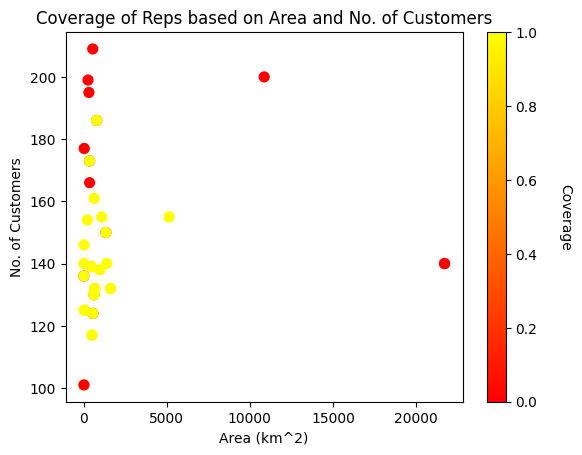

In [103]:
plt.scatter(X_test['Area'], X_test['Customers'], c=y_pred, s=50, cmap='autumn')
plt.xlabel('Area (km^2)')
plt.ylabel('No. of Customers')
plt.title('Coverage of Reps based on Area and No. of Customers')
colorbar = plt.colorbar()
colorbar.set_label('Coverage', rotation=270, labelpad=25)

plt.show()

We can notice that high number of customers with large area leads to lower probability of coverage.
Using this model we can predict if a rep will be able to achieve the target frequence or not based on the assigned customers and their locations.